In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json
import skimage.io
import random
import tensorflow as tf

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
class OneHotEncoder(object):
    def __init__(self, tags):
        self.tags = tags
        self.dict = {}
        for i, tag in enumerate(tags):
            self.dict[tag] = i
    
    def encode(self, tags, max_batch_length=64):
        result = [0] * max_batch_length
        for tag in tags:
            if tag in self.tags:
                result[self.dict[tag]] = 1
        result = tf.convert_to_tensor(result, dtype=tf.dtypes.int64)
        return result
    
    def decode(self, encoded):
        result = []
        encoded = encoded.numpy().tolist()
        for i, true in enumerate(encoded):
            if true:
                result.append(self.tags[i])
        return result

In [3]:
base_metadata_path = "../datasets/archive/danbooru-metadata/danbooru-metadata"
base_image_path = "../datasets/archive/danbooru-images/danbooru-images"
tags = ['1boy', '1girl', '2girls', '3girls', 'ahoge', 'animal_ears', 'bangs', 'bare_shoulders', 'black_legwear', 'blush', 'boots', 'bow', 'braid', 'breasts', 'cleavage', 'closed_eyes', 'detached_sleeves', 'dress', 'flower', 'food', 'full_body', 'glasses', 'gloves', 'hat', 'heart', 'holding', 'jacket', 'japanese_clothes', 'jewelry', 'large_breasts', 'long_hair', 'long_sleeves', 'male_focus', 'medium_breasts', 'multiple_boys', 'multiple_girls', 'navel', 'necktie', 'one_eye_closed', 'open_mouth', 'panties', 'pantyhose', 'ponytail', 'ribbon', 'school_uniform', 'shirt', 'shoes', 'short_hair', 'simple_background', 'sitting', 'skirt', 'smile', 'solo', 'standing', 'swimsuit', 'sword', 'tail', 'thighhighs', 'twintails', 'underwear', 'very_long_hair', 'weapon', 'white_background', 'wings']
encoder = OneHotEncoder(tags)

In [4]:
def fix_dim(img):
    if len(img.shape) == 3:
        return img
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

In [6]:
import tensorflow.keras.preprocessing.image as kimg

def load_image(path):
    x = kimg.load_image(path)
    x = kimg.image_to_array(x)
    return resize(fix_dim(x), (380, 380))

In [7]:
import json
import time

def image_gen(batch_size=64, train=True):
    x = []
    y = []


    batcher = get_one()

    while True:
        x, y = next(batcher)
        num = random.randint(0, 19)
        if num % 20 == 0 and train: continue
        if num % 20 != 0 and (not train): continue

        x.append(x)
        y.append(y)

        if len(x) == batch_size:
            yield x, y
            x = []
            y = []


def get_one():
    for file in os.listdir(base_metadata_path):
        with open(os.path.join(base_metadata_path, file), 'r') as f:
            for i, line in enumerate(f):
                j = json.loads(line)

                # get json fields
                image_id = j['id']
                ext = j['file_ext']
                tags = j['tags']

                # get tag names and ids
                tag_names = list(map(lambda t: t['name'], tags))

                # dir of the image
                image_path = str(int(image_id) % 1000).zfill(4)

                # path to image
                path = os.path.join(base_image_path, image_path, image_id) + f'.{ext}'
                # due to the smaller subset, not all images are available (?)
                if os.path.exists(path):
                    x = load_image(path)
                    y = encoder(tag_names)
                    yield x, y

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32, dim=(384, 384), n_channels=3, n_classes=10, shuffle=True, train=True):
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.validation_data = not train

    def __len__(self):
        return

    def __getitem__(self, index):
        return next(image_gen(batch_size=self.batch_size, train=self.train))

In [19]:
from distutils.version import LooseVersion
from skimage import transform

def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)

def load_image(path):
    x = tf.convert_to_tensor(resize(fix_dim(skimage.io.imread(path)), (380, 380)), dtype = tf.dtypes.float32)
    return fix_dim(x)

In [20]:
def data(training=True):
    random.seed(39)
    for file in os.listdir(base_metadata_path):
        with open(os.path.join(base_metadata_path, file), 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                num = random.randint(0, 19)
                if num % 20 == 0 and training: continue
                if num % 20 != 0 and (not training): continue
                j = json.loads(line)
                
                # get json fields
                image_id = j['id']
                ext = j['file_ext']
                tags = j['tags']
            
                # get tag names and ids
                tag_names = list(map(lambda t: t['name'], tags))
            
                # dir of the image
                image_path = str(int(image_id) % 1000).zfill(4)
            
                # path to image
                path = os.path.join(base_image_path, image_path, image_id) + f'.{ext}'
                # due to the smaller subset, not all images are available
                if os.path.exists(path):
                    x = load_image(path)
                    y = tag_names
                    y = encoder.encode(y)
                    yield x, y

In [28]:
train_dataset = tf.data.Dataset.from_generator(data,
                                                   output_signature=(
                                                       tf.TensorSpec(shape=(380, 380, 3)),
                                                       tf.TensorSpec(shape=[64])
                                                   )).batch(batch_size=5)
valid_dataset = tf.data.Dataset.from_generator(lambda: data(False),
                                                   output_signature=(
                                                       tf.TensorSpec(shape=(380, 380, 3)),
                                                       tf.TensorSpec(shape=[64])
                                                   )).batch(batch_size=5)

In [82]:
train_dataset = DataGenerator(batch_size=64, train=True)
valid_dataset = DataGenerator(batch_size=64, train=False)

In [46]:
model = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling="avg",
    classifier_activation="sigmoid",
    classes=64,
)

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=6000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(1)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-7)

Text(0.5, 0, 'Train Step')

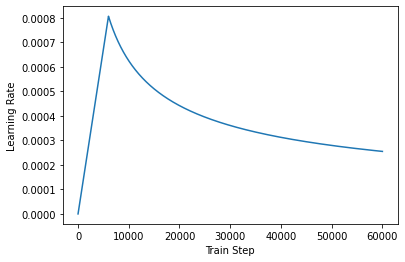

In [48]:
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(256)

plt.plot(temp_learning_rate_schedule(tf.range(300000 / 5, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [49]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

In [50]:
hist = model.fit(x=train_dataset, validation_data=valid_dataset, epochs=1)

   8398/Unknown - 5016s 596ms/step - loss: 0.3250 - accuracy: 0.4749

E:\Anaconda\envs\Project-Fugu-Manga-Translator\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


   9139/Unknown - 5476s 598ms/step - loss: 0.3221 - accuracy: 0.4650

KeyboardInterrupt: 

In [52]:
model.save("./test")

INFO:tensorflow:Assets written to: ./test\assets


NotImplementedError: Learning rate schedule must override get_config

In [85]:
wee = valid_dataset.take(20)

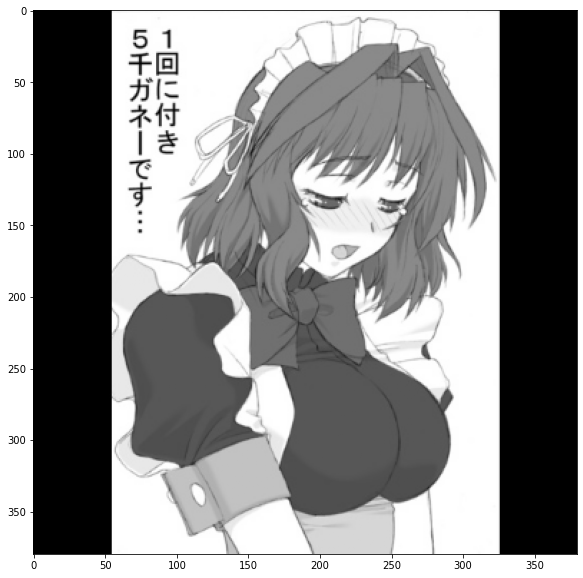

In [89]:
plt.figure(figsize=(10, 10))
plt.imshow(list(wee)[0][0][4].numpy())


In [91]:
encoder.decode((model(tf.expand_dims(list(wee)[0][0][0], axis=0)) > 0.5)[0])

[]

In [93]:
(model(tf.expand_dims(list(wee)[0][0][0], axis=0)) > 0.3)[0]

<tf.Tensor: shape=(64,), dtype=bool, numpy=
array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False])>